In [146]:
import pandas as pd
import time
from datetime import datetime
from pandas import ExcelWriter 
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
sns.set()

pd.__version__




ModuleNotFoundError: No module named 'seaborn'

In [147]:
# temp=1588744463872/1000
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(temp))

'2020-05-06 13:54:39'

In [148]:
temp=1588744479826/1000
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(temp))

'2020-05-06 13:54:39'

In [149]:
    # Total number of seconds between dates

In [150]:
class JTLReader:
    def __init__(self,jtlPath):
        self.jtlPath=jtlPath
        self.jtlColumns = ['timeStamp', 'elapsed','label','threadName','dataType','bytes','sentBytes','URL','allThreads','success','responseCode','responseMessage']
        self.df_Jtl=pd.read_csv(self.jtlPath,usecols=self.jtlColumns,dtype={'label':'category'})#dtype={'label':'category'},nrows=195222    
        self.df_Jtl.sort_values(by=['timeStamp'],inplace=True) 
        self.df_Jtl.reset_index(drop=True, inplace=True)
        self.shape=self.df_Jtl.shape
        self.rows=self.shape[0]
        self.rows
        """Conver Epoc time to Actual Time Start"""
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'],unit='ms')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')#reduce precision pandas timestamp dataframe
        self.df_Jtl['timeStamp']=self.df_Jtl['timeStamp'].dt.tz_localize('utc').dt.tz_convert('Singapore')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype(str).str[:-6]
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'])
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')
        """Conver Epoc time to Actual Time End"""
        
      

        """Saving master data frame to export to excel"""
        
        
        """Filter Transaction Controller & HTTP Request"""
        self.filt=(pd.isnull(self.df_Jtl['URL'])) #& (pd.isnull(self.df_Jtl['dataType']))
        self.df_jtl_TC=self.df_Jtl.loc[self.filt]
        self.df_jtl_HTTPReqeust=self.df_Jtl.loc[~self.filt]
        """Error Handling To be updated"""
        self.error_filt=(self.df_jtl_HTTPReqeust['success']==False) | (self.df_jtl_HTTPReqeust['success']==True)
        self.df_HttpErrors=self.df_jtl_HTTPReqeust.loc[self.error_filt]      
          
              
        
    """def getTransactionControllerData(self):
        print("Hello shiva")
        filt=(pd.isnull(self.df_Jtl['URL'])) & (pd.isnull(self.df_Jtl['dataType']))
        self.df_jtl_TC=self.df_Jtl.loc[filt]
        return self.df_jtl_TC"""
        

        
    def converTimeStamp(self):
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'],unit='ms')
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]')#reduce precision pandas timestamp dataframe
        self.df_Jtl['timeStamp']=self.df_Jtl['timeStamp'].dt.tz_localize('utc').dt.tz_convert('Africa/Cairo')#Africa/Cairo
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype(str).str[:-6]
        self.df_Jtl['timeStamp'] = pd.to_datetime(self.df_Jtl['timeStamp'])
        self.df_Jtl['timeStamp'] = self.df_Jtl['timeStamp'].astype('datetime64[s]') 
        
    def ms_to_sec(self):
         self.df_Jtl['elapsed']=((self.df_Jtl['elapsed'])/1000)
        
        
    def overAllResponseTimeSummary(self):
        self.df_overAllResponseTimeSummary=self.df_jtl_TC[['timeStamp','elapsed']]
        return self.df_overAllResponseTimeSummary
       
    def listOfErrors(self):
        return self.df_Jtl['responseCode'].value_counts()
    
    def shapeOfDaraFrame(self):
        return self.df_Jtl.shape
    
    def columnType(self,columnName):
        self.columnName=columnName
        return self.df_Jtl[self.columnName].dtype
    
    def getPeriod(self):
        self.startTime=self.df_Jtl['timeStamp'][0]
        self.endRow=self.df_Jtl['timeStamp'].shape[0]
        self.endTime=self.df_Jtl['timeStamp'][self.endRow-1]
        return f'{self.startTime} : {self.endTime}'
    
    def getDuration(self):
        self.startTime= self.df_Jtl['timeStamp'][0]
        self.endRow= self.df_Jtl['timeStamp'].shape[0]
        self.endTime= self.df_Jtl['timeStamp'][self.endRow-1]#-1
        self.executionStartTime=datetime(self.startTime.year,self.startTime.month,self.startTime.day,self.startTime.hour,self.startTime.minute,self.startTime.second)
        self.executionEndTime=datetime(self.endTime.year,self.endTime.month,self.endTime.day,self.endTime.hour,self.endTime.minute,self.endTime.second)
        self.timeDiff = self.executionEndTime-self.executionStartTime
        self.duration_in_s = self.timeDiff.total_seconds()
        self.duration=time.strftime("%H:%M:%S", time.gmtime(self.duration_in_s))
        return self.duration
    
    def getMaxRunningVusers(self):
        self.allThread=self.df_Jtl['allThreads'].max()
        return self.allThread 
    
      
    def getTotalHits(self):
        return self.df_jtl_HTTPReqeust.shape[0]
    
    def getAvgHitsPerSecond(self):
        return self.df_jtl_HTTPReqeust.shape[0]/self.duration_in_s
    
    def getTotalThroughput(self):
        self.totalThroughput=self.df_jtl_TC['bytes'].sum()
        return self.totalThroughput
    
    def getAvgThroughputPerSecond(self):
        self.avgThroughput=(self.df_jtl_TC['bytes'].sum())/self.duration_in_s
        return self.avgThroughput
    
    def getTotalPassFailFreqList(self):
        self.passFail_freq=self.df_jtl_TC['success'].value_counts().to_frame()
        #self.passFailFrequencyeqList=self.passFail_freq.index.tolist()
        
        return self.passFail_freq      
    
    def getTotalErrors(self):
        self.totalError=self.df_HttpErrors[['responseCode']].groupby(['responseCode'])
        self.totalError=self.df_HttpErrors['responseCode'].count()
        return self.totalError

    def getAnalysisSummary(self):
        self.period=self.getPeriod()
        self.duration=self.getDuration()
        self.maxRunningVusers=self.getMaxRunningVusers()
        self.totalThroughput=self.getTotalThroughput()
        self.avgThroughputPerSecond=self.getAvgThroughputPerSecond()
        self.totalHits=self.getTotalHits()
        self.avgHitsPerSecond=self.getAvgHitsPerSecond()
        self.totalErrors=self.getTotalErrors()
        self.df_AnalysisSummary=pd.DataFrame(
            {
                'Data':[
                        'Period','Duration','Maximum Running Vusers','Total bytes',
                        'Average bytes/second','TotalHits','Average Hits Per Second',
                        'Total Error','Total Pass','Total Failed'
                ],
                'Values':[
                            self.period,self.duration,self.maxRunningVusers,self.totalThroughput,
                            self.avgThroughputPerSecond,self.totalHits,self.avgHitsPerSecond,
                            self.totalErrors,self.getTotalPassFailFreqList(),'NA'
                ]
                
            }
        )
        return self.df_AnalysisSummary
    
    def responseTimeSummary(self):
        self.df_responseTimeSummary=self.df_jtl_TC[['label','elapsed']]
        self.df_txnGroup=self.df_responseTimeSummary.groupby(['label'],observed=True )  #observed=True      
        self.df_txnGroup=self.df_txnGroup['elapsed'].describe(percentiles=[.90])#self.df_txnGroup.describe(percentiles=[.90])
        self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(0)#self.df_txnGroup.columns=self.df_txnGroup.columns.get_level_values(1)
        self.df_txnGroup = self.df_txnGroup[['count','min','mean','90%','max',]]
        self.df_txnGroup.rename(columns={'count':'#Samples','min':'Min','mean':'Average','90%':'90 Percentile','max':'Max'},inplace=True)
        ##self.df_txnGroup=self.df_txnErrorGroup.reset_index() """To be enable if you run describe () on data frame. Now we are running on specific column"""
        ##self.df_txnGroup['throughput']=self.df_txnGroup['count']/self.duration_in_s
        ##self.validTxn_filt=(self.df_txnGroup['count']>0)
        self.df_responseTimeSummaryOutput=self.df_txnGroup #self.df_txnGroup[self.validTxn_filt]
       
        return self.df_responseTimeSummaryOutput
    
    def getPassFailSummary(self):
        self.df_passFailSummary=self.df_jtl_TC[['label','success']]
        self.df_passFailGroup=self.df_passFailSummary.groupby(['label'],observed=True)#whe we use observed=True-->refer https://stackoverflow.com/questions/54922327/valueerror-operands-could-not-be-broadcast-together-with-shape-when-calling-pan?answertab=votes#tab-top
        self.df_txnGroup=self.df_passFailGroup['success'].value_counts()
        self.df_txnGroupSlice=self.df_txnGroup.loc[:,]
        self.df_passFailSummaryOutput=self.df_txnGroupSlice.unstack()
        self.df_passFailSummaryOutput=self.df_passFailSummaryOutput.fillna(0)
        self.df_passFailSummaryOutput.rename(columns={True:'Pass',False:'Fail'},inplace=True)
        return self.df_passFailSummaryOutput
        
    def getFinalResponseSummary(self):
        rs=pd.merge(self.df_responseTimeSummaryOutput,self.df_passFailSummaryOutput,left_index=True,right_index=True)
        if 'Fail' in rs.columns:# If transaction fail observed 
            rs['Error%']=((rs['Fail'])/(rs['#Samples']))*100 
            rs=rs[['#Samples','Pass','Fail','Error%','Min','Average','90 Percentile','Max']]#'Fail','Error%'
            return rs
        else:# All transactions pass
            rs=rs[['#Samples','Pass','Min','Average','90 Percentile','Max']]
            
            return rs
            
            
    
    def getRunnerVuserGraphData(self):
        '''T=min,S=Seconds'''       
        self.df_vusers=self.df_jtl_TC[['timeStamp','allThreads']]
        self.df_vusers.sort_values(by=['timeStamp'])
        self.df_vusers.set_index('timeStamp',inplace=True)
        self.df_vusers_summary = pd.DataFrame()
        self.df_vusers_summary['Vusers']=self.df_vusers['allThreads'].resample('10S').max()  
        self.df_vusers_summary.ffill(inplace=True)
        return self.df_vusers_summary
         
        
    
    def getHitsPersecondGraphData(self):
        '''T=min,S=Seconds'''
        #self.df_jtl_HTTPReqeust['hits']=1
        self.df_hits=self.df_jtl_HTTPReqeust[['timeStamp','URL']]#self.df_jtl_HTTPReqeust[['timeStamp','hits']]
        #self.df_hits.sort_values(by=['timeStamp'])
        self.df_hits.set_index('timeStamp',inplace=True)
        self.df_hits_summary = pd.DataFrame()
        self.df_hits_summary['hitsCount']=self.df_hits['URL'].resample('10S').count()/60   
        #df.loc[(df!=0).any(axis=1)]
        self.df_hits_summary=self.df_hits_summary.loc[(self.df_hits_summary!=0).any(axis=1)]
        return self.df_hits_summary
        #return self.df_hits
    
    def getThrouhputPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_throughput=self.df_jtl_TC[['timeStamp','bytes']]
        #self.df_throughput.sort_values(by=['timeStamp'])
        self.df_throughput.set_index('timeStamp',inplace=True)
        self.df_throughput_summary = pd.DataFrame()
        self.df_throughput_summary['ThroughputReceived']=self.df_throughput['bytes'].resample('10S').sum()/60 
        return self.df_throughput_summary.astype(int)
        
    
    def getThrouhputSendPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_throughputsend=self.df_jtl_TC[['timeStamp','sentBytes']]
        #self.df_throughputsend.sort_values(by=['timeStamp'])
        self.df_throughputsend.set_index('timeStamp',inplace=True)
        self.df_throughputsend_summary = pd.DataFrame()
        self.df_throughputsend_summary['ThroughputSend']=self.df_throughputsend['sentBytes'].resample('10S').sum()/60    
        return self.df_throughputsend_summary.astype(int)
    
    def getErrorPersecondGraphData(self):
        '''T=min,S=Seconds'''
        self.df_errorCode=self.df_HttpErrors[['timeStamp','responseCode']]
        #self.df_throughputsend.sort_values(by=['timeStamp'])
        self.df_errorCode.set_index('timeStamp',inplace=True)
        self.df_errorCode_summary = pd.DataFrame()
        self.df_errorCode_summary['HTTPError']=self.df_errorCode['responseCode'].resample('1T').count() 
        return self.df_errorCode_summary
    
    def gerErrorPivot(self):
        self.df_df_HttpErrors_pivot=self.df_HttpErrors[['timeStamp','responseCode','responseMessage']]
        return self.df_df_HttpErrors_pivot.pivot_table(index=pd.Grouper(freq='T',key='timeStamp'),columns="responseMessage",aggfunc="count")        
 
    
    def getOverallResponseTime(self):
        return self.df_jtl_TC[['timeStamp','elapsed','label']]
    
    def getRawDataFrame(self):
        return self.df_Jtl
    
#     def get errorSummary(self):
#         self.filt_error=(self.df_jtl_HTTPReqeust['responseCode']!=200) & (self.df_jtl_HTTPReqeust['responseCode']!=202)
#         self.df_error=self.df_jtl_HTTPReqeust[self.filt_error]
#         return self.df_error
    
    def temp(self):
        self.slicer_grp=self.df_jtl_TC[['timeStamp','elapsed','label']]
        self.slicer_grp.sort_values(by=['timeStamp'])
        self.slicer_grp.set_index('timeStamp',inplace=True)
        self.df_response_summary_slicer = pd.DataFrame()
        self.df_slicer_txnGroup=self.slicer_grp.groupby(['label'],observed=True )
        self.df_response_summary_slicer=self.df_slicer_txnGroup['elapsed'].resample('30T').agg(['min','mean','max','count'])
        return self.df_response_summary_slicer
    
    def getDetailHttpErrors(self):
        self.df_errors=self.df_HttpErrors[['timeStamp','label','responseCode','responseMessage']]
        return  self.df_errors
    
    def getHttpErrorSummary(self):
        self.df_HttpErrorSummary=self.df_HttpErrors[['responseCode','responseMessage']].groupby(['responseCode'])
        self.df_HttpErrorSummary=self.df_HttpErrors['responseCode'].value_counts()
        return self.df_HttpErrorSummary
    
    
      
obj1=JTLReader("D:\\Projects\\AllSec\\Scripts\\Reports\\smoketest_02_Apr\\SmokeTest1_85Users_02APR_output.jtl") 
#obj1.converTimeStamp()
obj1.ms_to_sec() 
obj1.getDuration()



'01:10:32'

In [151]:
#obj1.gerErrorPivot()

In [152]:
#obj1.getHttpErrorSummary()

In [153]:
#y=obj1.getTotalPassFailFreqList()
#y

In [154]:
#x=obj1.temp()
#x

In [155]:
#obj1.df_Jtl

In [156]:
#obj1.df_jtl_HTTPReqeust

In [157]:
#obj1.df_jtl_TC

In [158]:
#obj1.getPeriod()

In [159]:
#obj1.getDuration()

In [160]:
#obj1.getMaxRunningVusers()

In [161]:
#obj1.getTotalThroughput()

In [162]:
"""Analysis Summery"""
analysisSummary=obj1.getAnalysisSummary()
analysisSummary


,Data,Values
0,Period,2021-04-02 16:33:45 : 2021-04-02 17:44:17
1,Duration,01:10:32
2,Maximum Running Vusers,85
3,Total bytes,2264233482
4,Average bytes/second,535026.815217
5,TotalHits,112359
6,Average Hits Per Second,26.549858
7,Total Error,112359
8,Total Pass,success True 5907 False 5
9,Total Failed,NA


In [163]:
"""responseTimeSummary"""
pd.set_option('display.max_rows',200)
responseTimeSummary=obj1.responseTimeSummary()
responseTimeSummary.head(100)

,#Samples,Min,Average,90 Percentile,Max
label,,,,,
001_AccessURL,366.0,147.0,5.660956e+02,1305.0,4668.0
002_Login,364.0,436.0,1.169723e+04,20720.2,154416.0
SCN01_EmployeeAttendanceview_Txn01_ClickAttendanceView,109.0,622.0,1.908626e+04,29805.8,75637.0
SCN11_HRBP_AttendanceCorrection_Txn01_AttendanceCorrection,16.0,338.0,8.191250e+02,1351.5,3654.0
SCN05_SupervisorFlexiCategoryBookedStatus_Txn01_FlexiShiftBookedStatus,125.0,597.0,1.925640e+03,3699.8,17492.0
SCN08_TL_FlexiRoster_Tx01_RosterFlexiBookedStatus,140.0,611.0,1.658257e+03,3388.5,8853.0
SCN10_AMHR_Attendance_Upload_Tx01_AttendanceDataUpload,273.0,344.0,5.217795e+03,6152.2,10016.0
SCN08_TL_FlexiRosterBookedStatus_Txn02_StartDate,140.0,1305.0,5.144471e+03,9819.9,20617.0
SCN14_HRBP_AttendanceDetail Report_Txn01_AttendanceDetailReport,5.0,315.0,2.086800e+03,3682.8,4002.0


In [164]:
"""Get Pass and Fail Summary"""
passandfail=obj1.getPassFailSummary()
passandfail

success,Fail,Pass
label,,
001_AccessURL,0.0,366.0
002_Login,0.0,364.0
SCN01_EmployeeAttendanceview_Txn01_ClickAttendanceView,0.0,109.0
SCN11_HRBP_AttendanceCorrection_Txn01_AttendanceCorrection,0.0,16.0
SCN05_SupervisorFlexiCategoryBookedStatus_Txn01_FlexiShiftBookedStatus,0.0,125.0
SCN08_TL_FlexiRoster_Tx01_RosterFlexiBookedStatus,0.0,140.0
SCN10_AMHR_Attendance_Upload_Tx01_AttendanceDataUpload,0.0,273.0
SCN08_TL_FlexiRosterBookedStatus_Txn02_StartDate,0.0,140.0
SCN14_HRBP_AttendanceDetail Report_Txn01_AttendanceDetailReport,0.0,5.0


In [165]:
"""Get Final Response Summary"""
rs=obj1.getFinalResponseSummary()
rs

,#Samples,Pass,Fail,Error%,Min,Average,90 Percentile,Max
label,,,,,,,,
001_AccessURL,366.0,366.0,0.0,0.0,147.0,5.660956e+02,1305.0,4668.0
002_Login,364.0,364.0,0.0,0.0,436.0,1.169723e+04,20720.2,154416.0
SCN01_EmployeeAttendanceview_Txn01_ClickAttendanceView,109.0,109.0,0.0,0.0,622.0,1.908626e+04,29805.8,75637.0
SCN11_HRBP_AttendanceCorrection_Txn01_AttendanceCorrection,16.0,16.0,0.0,0.0,338.0,8.191250e+02,1351.5,3654.0
SCN05_SupervisorFlexiCategoryBookedStatus_Txn01_FlexiShiftBookedStatus,125.0,125.0,0.0,0.0,597.0,1.925640e+03,3699.8,17492.0
SCN08_TL_FlexiRoster_Tx01_RosterFlexiBookedStatus,140.0,140.0,0.0,0.0,611.0,1.658257e+03,3388.5,8853.0
SCN10_AMHR_Attendance_Upload_Tx01_AttendanceDataUpload,273.0,273.0,0.0,0.0,344.0,5.217795e+03,6152.2,10016.0
SCN08_TL_FlexiRosterBookedStatus_Txn02_StartDate,140.0,140.0,0.0,0.0,1305.0,5.144471e+03,9819.9,20617.0
SCN14_HRBP_AttendanceDetail Report_Txn01_AttendanceDetailReport,5.0,5.0,0.0,0.0,315.0,2.086800e+03,3682.8,4002.0


In [166]:
"""Get Vuser Summary"""
runningVuser=obj1.getRunnerVuserGraphData()
runningVuser

,Vusers
timeStamp,
2021-04-02 16:33:40,85.0
2021-04-02 16:33:50,85.0
2021-04-02 16:34:00,85.0
2021-04-02 16:34:10,85.0
2021-04-02 16:34:20,85.0
...,...
2021-04-02 17:34:20,77.0
2021-04-02 17:34:30,71.0
2021-04-02 17:34:40,63.0


In [167]:
"""Get Hits Summary"""
hitsPersecond=obj1.getHitsPersecondGraphData() 
hitsPersecond

,hitsCount
timeStamp,
2021-04-02 16:33:40,5.483333
2021-04-02 16:33:50,29.083333
2021-04-02 16:34:00,16.233333
2021-04-02 16:34:10,49.900000
2021-04-02 16:34:20,36.900000
...,...
2021-04-02 17:38:20,0.183333
2021-04-02 17:38:30,0.183333
2021-04-02 17:39:30,0.366667


In [26]:
"""Get Throughput Received Summery"""
throughput=obj1.getThrouhputPersecondGraphData()
throughput

,ThroughputReceived
timeStamp,
2021-04-02 16:33:40,51294
2021-04-02 16:33:50,480278
2021-04-02 16:34:00,557870
2021-04-02 16:34:10,193524
2021-04-02 16:34:20,1031490
...,...
2021-04-02 17:34:20,51345
2021-04-02 17:34:30,15967
2021-04-02 17:34:40,18086


In [27]:
"""Get Throughput Send Summery"""
throughputsend=obj1.getThrouhputSendPersecondGraphData()
throughputsend

,ThroughputSend
timeStamp,
2021-04-02 16:33:40,5609
2021-04-02 16:33:50,46068
2021-04-02 16:34:00,51457
2021-04-02 16:34:10,9666
2021-04-02 16:34:20,45843
...,...
2021-04-02 17:34:20,8364
2021-04-02 17:34:30,2363
2021-04-02 17:34:40,1701


In [28]:
"""Get Error Summary"""
errors=obj1.getErrorPersecondGraphData()
errors

,HTTPError
timeStamp,
2021-04-02 16:33:00,2074
2021-04-02 16:34:00,6763
2021-04-02 16:35:00,1224
2021-04-02 16:36:00,2009
2021-04-02 16:37:00,1306
2021-04-02 16:38:00,1501
2021-04-02 16:39:00,2047
2021-04-02 16:40:00,1312
2021-04-02 16:41:00,1615


In [29]:
"""overAllResponseTimeSummary"""
overallResponseTime=obj1.getOverallResponseTime()
overallResponseTime

,timeStamp,elapsed,label
0,2021-04-02 16:33:45,559,001_AccessURL
4,2021-04-02 16:33:46,860,001_AccessURL
8,2021-04-02 16:33:46,638,001_AccessURL
9,2021-04-02 16:33:46,998,001_AccessURL
12,2021-04-02 16:33:46,553,001_AccessURL
...,...,...,...
117971,2021-04-02 17:35:02,104,SCN13_HRBP_RosterFlexiLiveDashBoard_Txn03_Tick...
117983,2021-04-02 17:35:02,2586,SCN13_HRBP_RosterFlexiLiveDashBoard_Txn04_Sele...
118009,2021-04-02 17:35:04,273,003_Logoff
118030,2021-04-02 17:35:06,236,003_Logoff


In [30]:
detailerrors=obj1.getDetailHttpErrors()
detailerrors

,timeStamp,label,responseCode,responseMessage
1,2021-04-02 16:33:45,/Atslstaging/Common/web_Signon.aspx-41,200,OK
2,2021-04-02 16:33:45,https://essstaging.allsechro.com/Atslstaging/C...,200,OK
3,2021-04-02 16:33:46,/AtslStaging/Common/web_Signon.aspx-3,200,OK
5,2021-04-02 16:33:46,https://essstaging.allsechro.com/AtslStaging/C...,200,OK
6,2021-04-02 16:33:46,/AtslStaging/Common/web_Signon.aspx-4,200,OK
...,...,...,...,...
118266,2021-04-02 17:44:17,https://essstaging.allsechro.com/Atslstaging/s...,200,OK
118267,2021-04-02 17:44:17,https://essstaging.allsechro.com/Atslstaging/S...,200,OK
118268,2021-04-02 17:44:17,https://essstaging.allsechro.com/Atslstaging/S...,200,OK
118269,2021-04-02 17:44:17,https://essstaging.allsechro.com/Atslstaging/S...,200,OK


In [31]:
errorPivot=obj1.gerErrorPivot()

In [32]:
obj1.getHttpErrorSummary()

200                                                      110874
302                                                         887
Non HTTP response code: java.net.UnknownHostException       546
Non HTTP response code: java.net.SocketException             45
Non HTTP response code: javax.net.ssl.SSLException            7
Name: responseCode, dtype: int64

In [33]:
rawdataframe=obj1.getRawDataFrame()
rawdataframe

,timeStamp,elapsed,label,responseCode,responseMessage,threadName,dataType,success,bytes,sentBytes,allThreads,URL
0,2021-04-02 16:33:45,0.559,001_AccessURL,200,"Number of samples in transaction : 1, number o...",SCN001_EmployeeAttendanceview 1-1,NaN,True,251300,16375,15,NaN
1,2021-04-02 16:33:45,0.559,/Atslstaging/Common/web_Signon.aspx-41,200,OK,SCN001_EmployeeAttendanceview 1-1,text,True,251300,16375,15,https://essstaging.allsechro.com/Atslstaging/C...
2,2021-04-02 16:33:45,0.093,https://essstaging.allsechro.com/Atslstaging/C...,200,OK,SCN001_EmployeeAttendanceview 1-1,text,True,14608,720,15,https://essstaging.allsechro.com/Atslstaging/C...
3,2021-04-02 16:33:46,0.860,/AtslStaging/Common/web_Signon.aspx-3,200,OK,SCN002_EmployeeFlexRosterShiftView 2-1,text,True,160366,14611,16,https://essstaging.allsechro.com/AtslStaging/C...
4,2021-04-02 16:33:46,0.860,001_AccessURL,200,"Number of samples in transaction : 2, number o...",SCN002_EmployeeFlexRosterShiftView 2-1,NaN,True,160366,14611,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
118266,2021-04-02 17:44:17,0.079,https://essstaging.allsechro.com/Atslstaging/s...,200,OK,SCN019_HRBP_LeaveBalanceReport 17-3,bin,True,1434,1089,7,https://essstaging.allsechro.com/Atslstaging/s...
118267,2021-04-02 17:44:17,0.007,https://essstaging.allsechro.com/Atslstaging/S...,200,OK,SCN019_HRBP_LeaveBalanceReport 17-3,bin,True,548,1087,7,https://essstaging.allsechro.com/Atslstaging/S...
118268,2021-04-02 17:44:17,0.005,https://essstaging.allsechro.com/Atslstaging/S...,200,OK,SCN019_HRBP_LeaveBalanceReport 17-3,bin,True,898,1089,7,https://essstaging.allsechro.com/Atslstaging/S...
118269,2021-04-02 17:44:17,0.004,https://essstaging.allsechro.com/Atslstaging/S...,200,OK,SCN019_HRBP_LeaveBalanceReport 17-3,bin,True,505,1090,7,https://essstaging.allsechro.com/Atslstaging/S...


In [34]:
"""Generate Excel Report"""
writer = ExcelWriter('PerformanceTestReport.xlsx',mode='w')
#Write Analysis Summary to Excel
analysisSummary.to_excel(writer,sheet_name='AnalysisSummary')
#write response summary to excel with txn name,min,avg,max,90% & max
rs.to_excel(writer,sheet_name='ResponseSummary')
#Write Running Vusers
runningVuser.to_excel(writer,sheet_name='RunningVuserSummary')
#Write Hits Summary
hitsPersecond.to_excel(writer,sheet_name='HitsSummary')
#Write Throughput Received Summary
throughput.to_excel(writer,sheet_name='ThroughputReceivedSummary')
#Write Throughput Send Summary
throughputsend.to_excel(writer,sheet_name='ThroughputSendSummary')
#Write error summary
errors.to_excel(writer,sheet_name='ErrorGraph')
#Write ResponseTime
overallResponseTime.to_excel(writer,sheet_name='ResponseTimeGraph')
#Write Detail Errors
detailerrors.to_excel(writer,sheet_name='DetailErrors')
#Write Error Pivot
errorPivot.to_excel(writer,sheet_name='ErrorPivot')
#Export Original dataframe
rawdataframe.to_excel(writer,sheet_name='dataframe')
writer.save()







PermissionError: [Errno 13] Permission denied: 'PerformanceTestReport.xlsx'

#Draw Running Vuser Graph

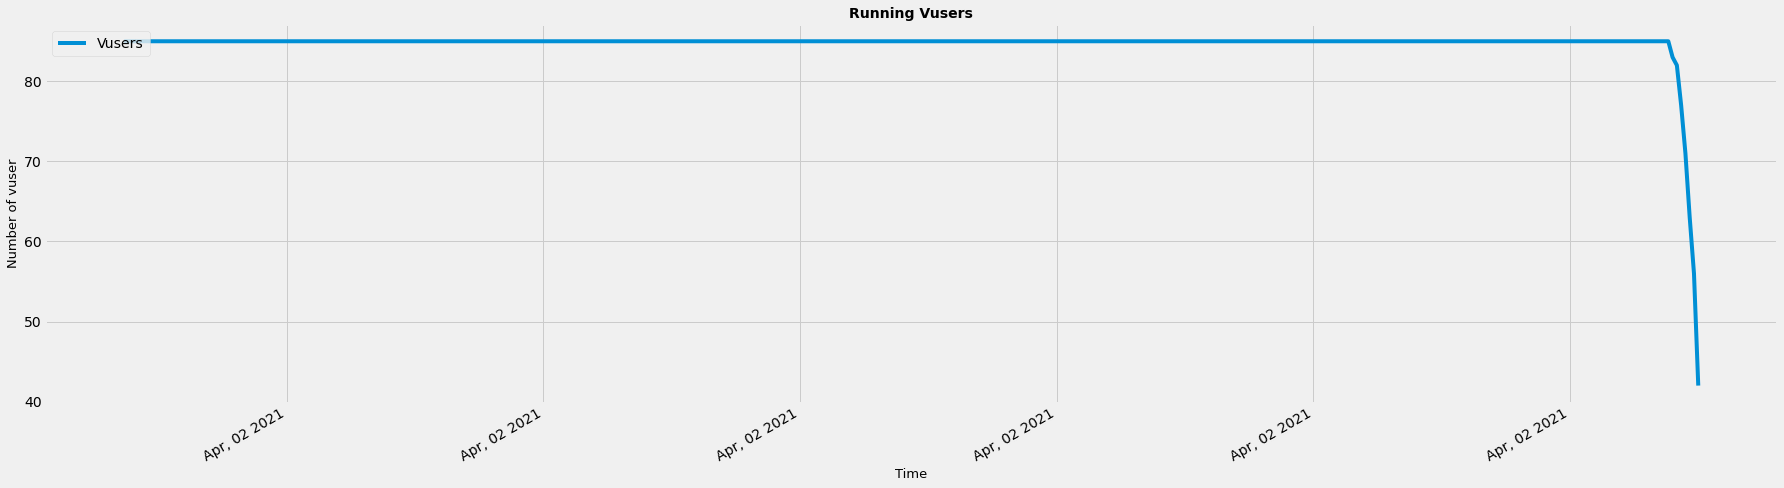

In [35]:
df_vuser=obj1.getRunnerVuserGraphData()
df_vuser.reset_index('timeStamp',inplace=True)
#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_vuser['timeStamp'],df_vuser['Vusers'],label='Vusers')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Running Vusers",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13)#,fontweight="bold"
plt.ylabel("Number of vuser",fontsize=13)#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()
#plt.savefig("Vuser.png")


In [36]:
#Draw Hits Summary

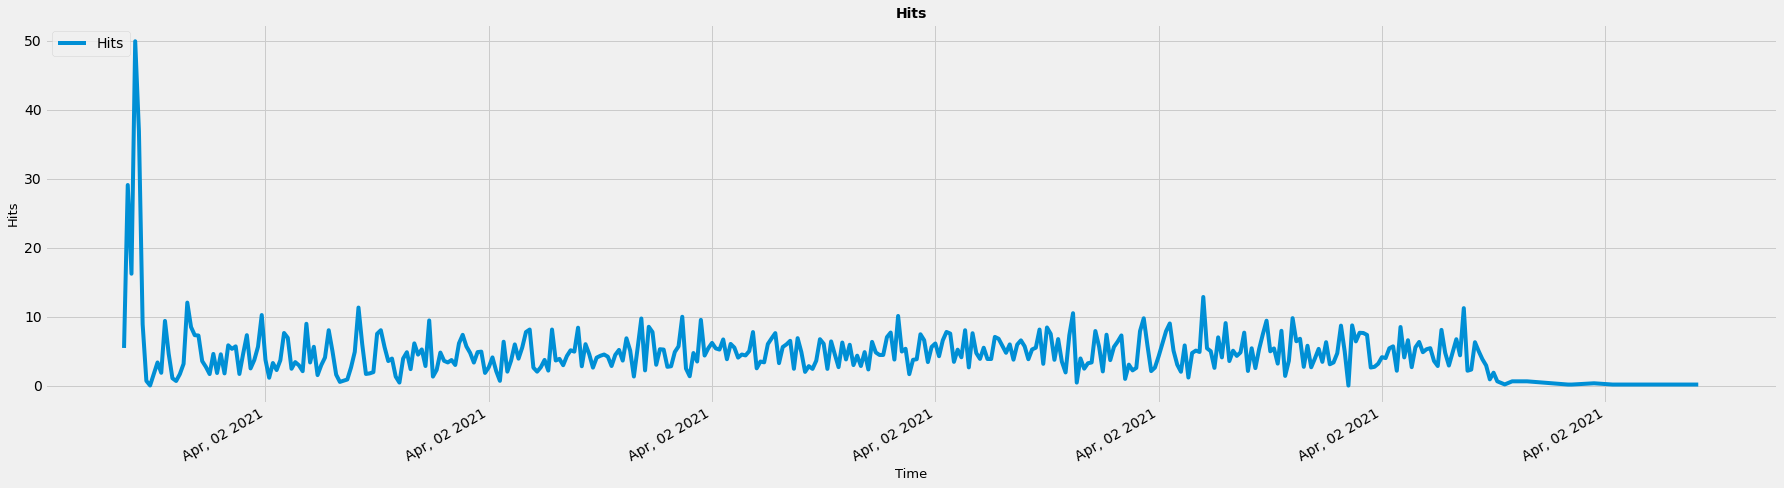

In [37]:
df_hits=obj1.getHitsPersecondGraphData()
df_hits.reset_index('timeStamp',inplace=True)
#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_hits['timeStamp'],df_hits['hitsCount'],label='Hits')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Hits",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13)#,fontweight="bold"
plt.ylabel("Hits",fontsize=13)#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()
#plt.savefig("Vuser.png")

In [38]:
#Draw Throughput Received

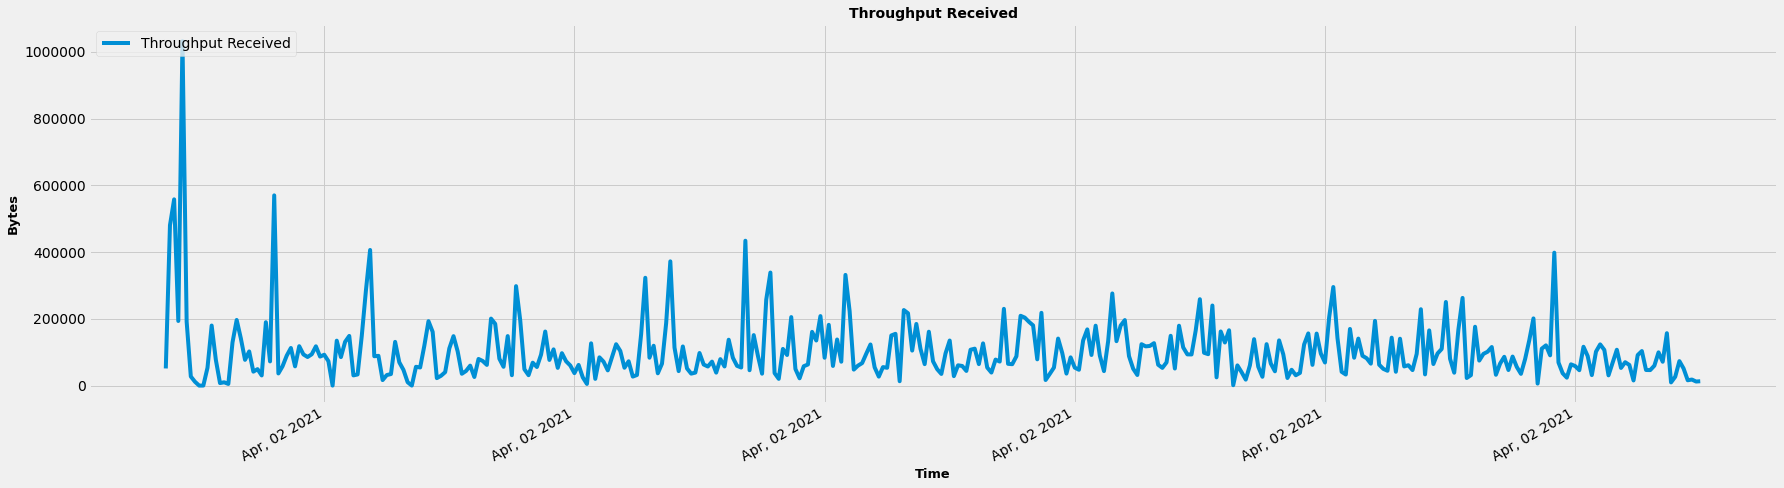

In [39]:
df_throughput=obj1.getThrouhputPersecondGraphData()
df_throughput.reset_index('timeStamp',inplace=True)


#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_throughput['timeStamp'],df_throughput['ThroughputReceived'],label='Throughput Received')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Throughput Received",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Bytes",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()


In [40]:
#Draw Throughput Send

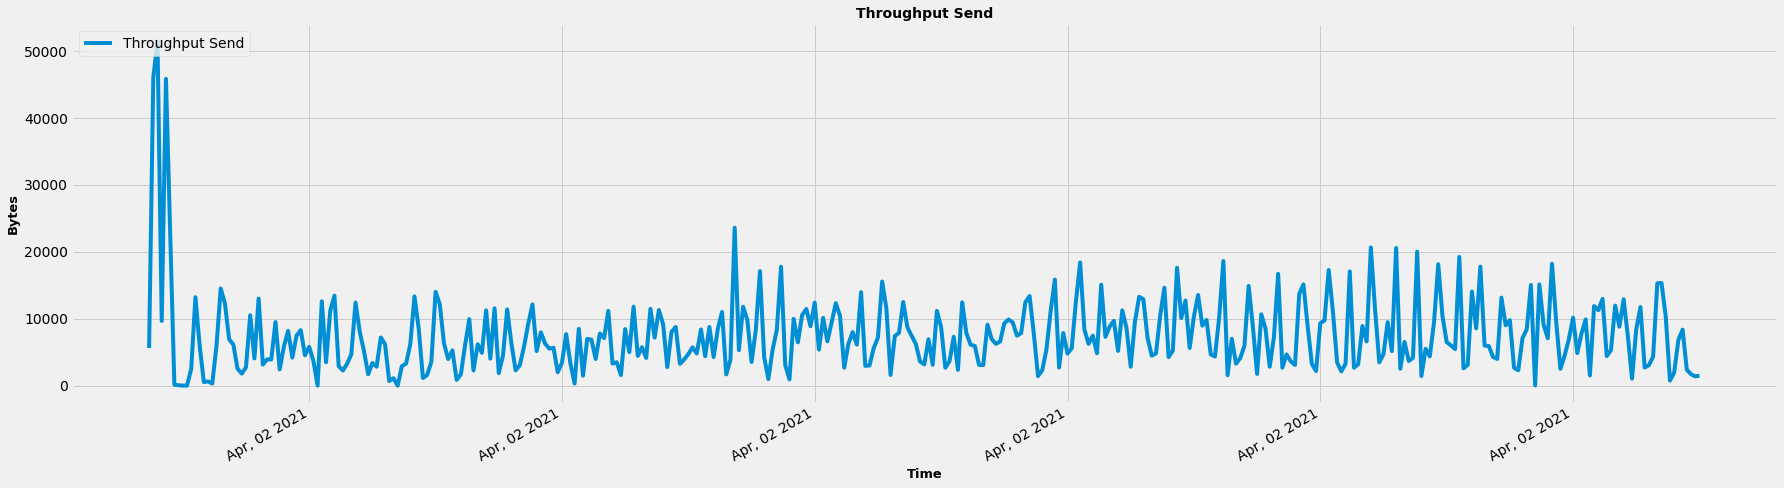

In [41]:
df_throughput_send=obj1.getThrouhputSendPersecondGraphData()
df_throughput_send.reset_index('timeStamp',inplace=True)

#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_throughput_send['timeStamp'],df_throughput_send['ThroughputSend'],label='Throughput Send')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Throughput Send",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Bytes",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()


In [42]:
#Draw Error Grph

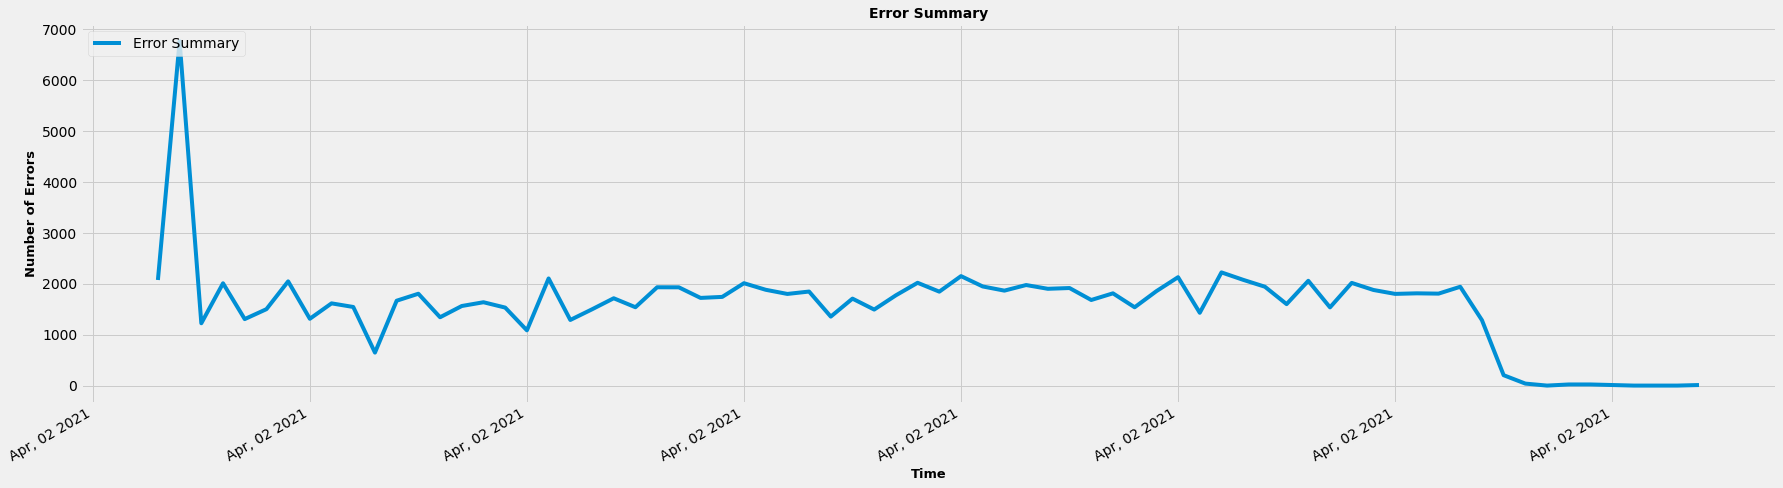

In [43]:
df_errors=obj1.getErrorPersecondGraphData()
df_errors.reset_index('timeStamp',inplace=True)

#Draw Graph
plt.style.use('fivethirtyeight')#print(plt.style.available)
plt.figure(figsize=(25,7))
plt.plot(df_errors['timeStamp'],df_errors['HTTPError'],label='Error Summary')#color="m",linestyle='-',linewidth=3,marker='.' #Important Line x & Y axis #crimson
plt.title("Error Summary",fontsize=14,fontweight="bold")
plt.xlabel("Time",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.ylabel("Number of Errors",fontsize=13,fontweight="bold")#,fontweight="bold"
plt.legend(loc='upper left')#This will take label name from plt.plot. So no need to pass the labe in sequence order
plt.gcf().autofmt_xdate()#plt.xticks(rotation=45,fontsize=13)
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain', axis='y')#To remove scientifice numbers
date_format=mpl_dates.DateFormatter('%b, %d %Y')#To formate the x axis with date format
plt.gca().xaxis.set_major_formatter(date_format)#To formate the x axis with date format
plt.tight_layout()#Automatically render without padding issue #plt.grid(True)
plt.show()

In [ ]:
#Draw Vuser Plotly

In [185]:
import plotly.offline as pyo
import plotly.graph_objs as go
import random
#'rgb(131, 90, 241)','rgb(127, 166, 238)','rgb(111, 231, 219)','rgb(184, 247, 212)'
colors = ['rgb(128,128,0)']

x_values=df_vuser['timeStamp']
y_values=df_vuser['Vusers']


trace1=go.Scatter(x=x_values,y=y_values,mode='lines',showlegend=True,stackgroup='one',name='runningvusers',line=dict(width=2, color=random.choice(colors)),connectgaps=True)#stackgroup='one',fillcolor='rgba(231,107,243,0.2)'
data=[trace1]
layout=go.Layout(title='Running Vuser Graph',xaxis=dict(title='Time'),yaxis=dict(title='Vusers'),hovermode='closest')

fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    template = 'plotly_dark',
    autosize=False,
    width=1200,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',    
    legend=dict(x=0.1,y=0.8,traceorder='normal'),
    title=dict(text='Running Vuser Graph',y=0.9,x=0.5,xanchor='center',yanchor='top'),
    title_font_family="Times New Roman",
    title_font_color='rgb(255,255,255)',

  annotations=[
        dict(xref='paper',x=0.90,y=40,xanchor='auto', yanchor='auto',font=dict(family='Arial',size=10),showarrow=False,
            text='Displays the number of Vusers that executed Vuser scripts,and their status,\nduring each second of a load test.\nThis graph is useful for determining the Vuser load on your server at any given moment')
    ]

)

#fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')


pyo.plot(fig,filename='RunningVusers.html')

'RunningVusers.html'

In [ ]:
#Draw Hits Plotly

In [186]:
import plotly.offline as pyo
import plotly.graph_objs as go
import random
#'rgb(131, 90, 241)','rgb(127, 166, 238)','rgb(111, 231, 219)','rgb(184, 247, 212)'
colors = ['rgb(127, 166, 238)']

x_values=df_hits['timeStamp']
y_values=df_hits['hitsCount']


trace1=go.Scatter(x=x_values,y=y_values,mode='lines',showlegend=True,name='Hits',line=dict(width=2, color=random.choice(colors)),connectgaps=True)#stackgroup='one',fillcolor='rgba(231,107,243,0.2)'
data=[trace1]
layout=go.Layout(title='Hits Graph',xaxis=dict(title='Time'),yaxis=dict(title='Hits'),hovermode='closest')

fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    template = 'plotly_dark',
    autosize=False,
    width=1200,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',    
    legend=dict(x=0.8,y=1,traceorder='normal'),
    title=dict(text='Hits Graph',y=0.9,x=0.5,xanchor='center',yanchor='top'),
    title_font_family="Times New Roman",
    title_font_color='rgb(255,255,255)',

  annotations=[
        dict(xref='paper',x=0.90,y=40,xanchor='auto', yanchor='auto',font=dict(family='Arial',size=10),showarrow=False,
            text='Displays the number of hits made on the Web server by Vusers during each second of the load test.This graph helps you evaluate the amount of load Vusers generate, in terms of the number of hits')
    ]

)

#fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')


pyo.plot(fig,filename='HitsGraph.html')

'HitsGraph.html'

In [170]:
#Draw Throughput Receive Graph

In [187]:
import plotly.offline as pyo
import plotly.graph_objs as go
import random
#'rgb(131, 90, 241)','rgb(127, 166, 238)','rgb(111, 231, 219)','rgb(184, 247, 212)'
colors = ['rgb(111, 231, 219)']

x_values=df_throughput['timeStamp']
y_values=df_throughput['ThroughputReceived']


trace1=go.Scatter(x=x_values,y=y_values,mode='lines',showlegend=True,stackgroup='one',name='Throughput Received',line=dict(width=2, color=random.choice(colors)),connectgaps=True)#stackgroup='one',fillcolor='rgba(231,107,243,0.2)'
data=[trace1]
layout=go.Layout(title='Throughput Receive Graph',xaxis=dict(title='Time'),yaxis=dict(title='bytes'),hovermode='closest')

fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    template = 'plotly_dark',
    autosize=False,
    width=1200,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',    
    legend=dict(x=0.8,y=1,traceorder='normal'),
    title=dict(text='Throughput Receive Graph',y=0.9,x=0.5,xanchor='center',yanchor='top'),
    title_font_family="Times New Roman",
    title_font_color='rgb(255,255,255)',

  annotations=[  #['auto', 'left', 'center', 'right']        #['auto', 'top', 'middle', 'bottom']
        dict(xref='paper',x=0.90,y=90,xanchor='right', yanchor='top',font=dict(family='Arial',size=10),showarrow=False,
            text='Displays the amount of throughput (in bytes) on the Web server during the load test.Throughput represents the amount of data that the Vusers received from the server ')
    ]

)

#fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')


pyo.plot(fig,filename='ThroughputReceiveGraph.html')

'ThroughputReceiveGraph.html'

In [ ]:
#Draw Throughput Send Graph

In [189]:
import plotly.offline as pyo
import plotly.graph_objs as go
import random
#'rgb(131, 90, 241)','rgb(127, 166, 238)','rgb(111, 231, 219)','rgb(184, 247, 212)'
colors = ['rgb(131, 90, 241)']

x_values=df_throughput_send['timeStamp']
y_values=df_throughput_send['ThroughputSend']


trace1=go.Scatter(x=x_values,y=y_values,mode='lines',showlegend=True,stackgroup='one',name='Throughput Send',line=dict(width=2, color=random.choice(colors)),connectgaps=True)#stackgroup='one',fillcolor='rgba(231,107,243,0.2)'
data=[trace1]
layout=go.Layout(title='Throughput Send Graph',xaxis=dict(title='Time'),yaxis=dict(title='bytes'),hovermode='closest')

fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    template = 'plotly_dark',
    autosize=False,
    width=1200,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',    
    legend=dict(x=0.8,y=1,traceorder='normal'),
    title=dict(text='Throughput Send Graph',y=0.9,x=0.5,xanchor='center',yanchor='top'),
    title_font_family="Times New Roman",
    title_font_color='rgb(255,255,255)',

  annotations=[  #['auto', 'left', 'center', 'right']        #['auto', 'top', 'middle', 'bottom']
        dict(xref='paper',x=1,y=90,xanchor='right', yanchor='top',font=dict(family='Arial',size=10),showarrow=False,
            text='Displays the amount of throughput (in bytes) on the Web server during the load test.Throughput represents the amount of data that the Vusers send to the server at any given second.This graph helps you to evaluate the amount of load ')
    ]

)

#fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')


pyo.plot(fig,filename='ThroughputSendGraph.html')

'ThroughputSendGraph.html'

In [ ]:
#Draw Error Graph

In [190]:
import plotly.offline as pyo
import plotly.graph_objs as go
import random
#'rgb(131, 90, 241)','rgb(127, 166, 238)','rgb(111, 231, 219)','rgb(184, 247, 212)'
colors = ['rgb(127, 166, 238)']

x_values=df_errors['timeStamp']
y_values=df_errors['HTTPError']


trace1=go.Scatter(x=x_values,y=y_values,mode='lines',showlegend=True,stackgroup='one',name='Errors',line=dict(width=2, color=random.choice(colors)),connectgaps=True)#stackgroup='one',fillcolor='rgba(231,107,243,0.2)'
data=[trace1]
layout=go.Layout(title='Error Graph',xaxis=dict(title='Time'),yaxis=dict(title='Number of Errors'),hovermode='closest')

fig=go.Figure(data=data,layout=layout)
fig.update_layout(
    template = 'plotly_dark',
    autosize=False,
    width=1200,
    height=400,
    plot_bgcolor='rgba(0,0,0,0)',    
    legend=dict(x=0.8,y=1,traceorder='normal'),
    title=dict(text='Errors Graph',y=0.9,x=0.5,xanchor='center',yanchor='top'),
    title_font_family="Times New Roman",
    title_font_color='rgb(255,255,255)',

 
)

#fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')
#fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='rgb(105,105,105)')


pyo.plot(fig,filename='Errors.html')

'Errors.html'